In [1]:
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import os

#Data Loading and Preprocessing

In [2]:
from kaggle_downloader import KaggleDatasetDownload

kaggle_dataset = "orvile/carotid-ultrasound-images"
downloader = KaggleDatasetDownload(kaggle_dataset, '/content')
path = downloader.download()

100%|██████████| 284M/284M [00:02<00:00, 123MB/s]

Extracting files...


Downloaded Successfully at: /content/datasets/orvile/carotid-ultrasound-images/versions/2


In [3]:
image_dir = path + '/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/US images'
mask_dir = path + '/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images'

In [4]:
print(f"Number of images: {len(os.listdir(image_dir))}\nNumber of masks: {len(os.listdir(mask_dir))}")

Number of images: 1100
Number of masks: 1100


In [5]:
image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])
mask_files = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir)])

In [6]:
df = pd.DataFrame({'image_path': image_files, 'mask_path': mask_files})
df.head()

,image_path,mask_path
0,/content/datasets/orvile/carotid-ultrasound-im...,/content/datasets/orvile/carotid-ultrasound-im...
1,/content/datasets/orvile/carotid-ultrasound-im...,/content/datasets/orvile/carotid-ultrasound-im...
2,/content/datasets/orvile/carotid-ultrasound-im...,/content/datasets/orvile/carotid-ultrasound-im...
3,/content/datasets/orvile/carotid-ultrasound-im...,/content/datasets/orvile/carotid-ultrasound-im...
4,/content/datasets/orvile/carotid-ultrasound-im...,/content/datasets/orvile/carotid-ultrasound-im...


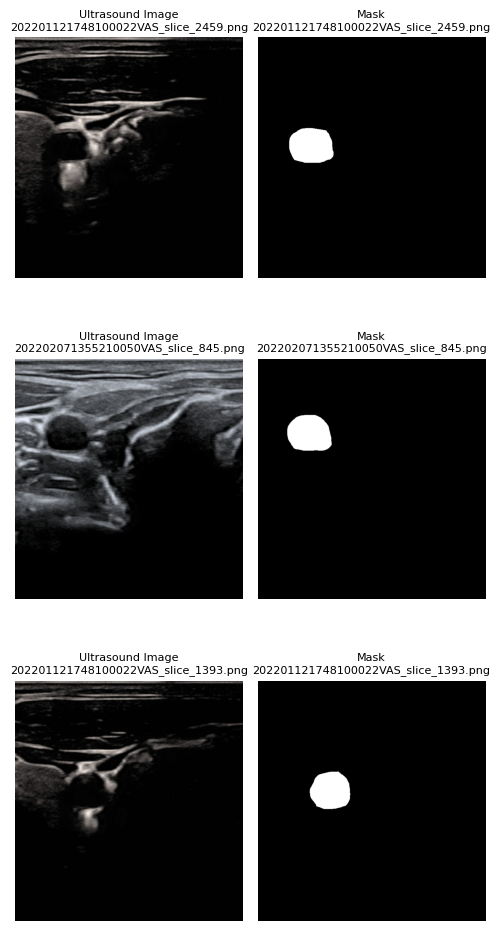

In [7]:
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))
assert all(image.split('.')[0] == mask.split('.')[0] for image,mask in zip(image_files, mask_files)), "Mismatched Files"

fig, axes = plt.subplots(3, 2, figsize=(5,10))

for i in range(3):
  random_index = random.randint(0, len(image_files)-1)
  image_path = os.path.join(image_dir, image_files[random_index])
  mask_path = os.path.join(mask_dir, mask_files[random_index])

  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

  axes[i, 0].imshow(img)
  axes[i, 0].set_title(f'Ultrasound Image\n{image_files[random_index]}',fontdict={'fontsize': 8})
  axes[i, 0].axis('off')

  axes[i, 1].imshow(msk, cmap='gray')
  axes[i, 1].set_title(f'Mask\n{mask_files[random_index]}',fontdict={'fontsize': 8})
  axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_data(df, image_size = (256,256)):

  images=[]
  masks=[]

  for image_path, mask_path in zip(df['image_path'], df['mask_path']):
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img)/255.0
    images.append(img)

    mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
    mask = img_to_array(mask)/255.0
    masks.append(mask)

  return np.array(images), np.array(masks)

images, masks = load_data(df)
masks = np.expand_dims(masks, axis=-1)

#U-Net Model

In [9]:
import tensorflow as tf
#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from unet_model import unet
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Training

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, verbose=1, factor=0.1)

history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9761 - loss: 0.3569 - val_accuracy: 0.9758 - val_loss: 0.0987 - learning_rate: 0.0010
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.9770 - loss: 0.0784 - val_accuracy: 0.9758 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.9769 - loss: 0.0590 - val_accuracy: 0.9758 - val_loss: 0.0613 - learning_rate: 0.0010
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9767 - loss: 0.0464 - val_accuracy: 0.9835 - val_loss: 0.0383 - learning_rate: 0.0010
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.9867 - loss: 0.0352 - val_accuracy: 0.9908 - val_loss: 0.0239 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9903 - loss: 0.0254
Test Loss: 0.0239
Test Accuracy: 0.9908


#Evaluation and Visualization

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
IOU: 0.6978
Dice: 0.8220


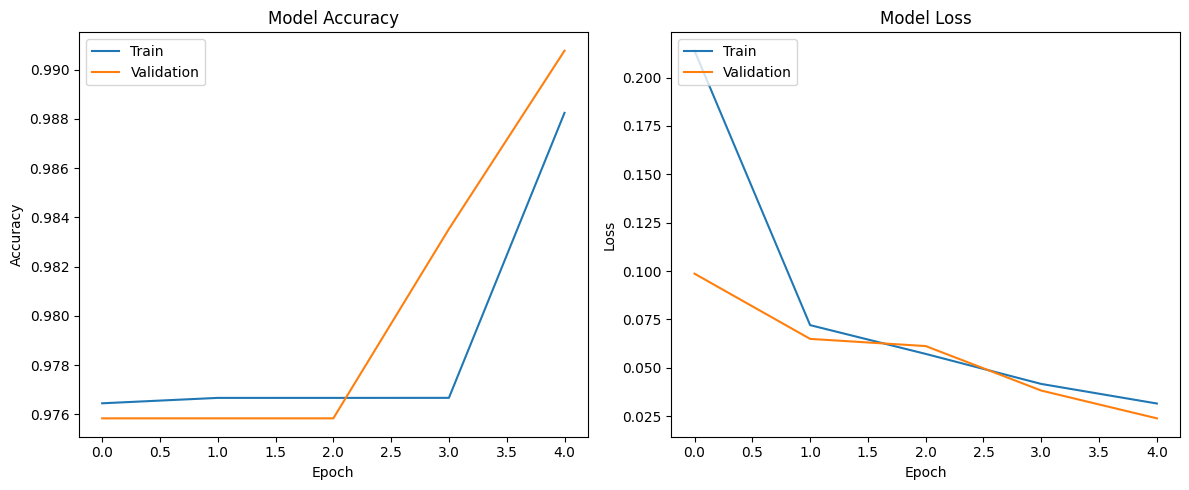

In [13]:
from utils import plot_history, calculate_iou, calculate_dice

y_pred_binary = (model.predict(X_test) > 0.5).astype(bool)
y_test_binary = (y_test).astype(bool)

iou = calculate_iou(y_test_binary.squeeze(), y_pred_binary.squeeze())
dice = calculate_dice(y_test_binary.squeeze(), y_pred_binary.squeeze())

print(f'IOU: {iou:.4f}')
print(f'Dice: {dice:.4f}')
plot_history(history)